In [ ]:
%pip install transformers -U

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
import torch
import torch.nn as nn
from transformers import TrainingArguments,Trainer
from transformers import BertTokenizer, BertModel
import kagglehub
import os
from torch.utils.data import DataLoader, TensorDataset
import gc  # For garbage collection
from tqdm import tqdm  # For progress tracking
import wandb
from wandb.integration.keras import WandbCallback

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdallaellaithy/330k-arabic-sentiment-reviews")

print("Path to dataset files:", path)

100%|██████████| 64.3M/64.3M [00:00<00:00, 114MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/abdallaellaithy/330k-arabic-sentiment-reviews/versions/1


In [4]:
# Assuming the CSV file is named 'data.csv' inside the downloaded directory
file_path = os.path.join(path, 'arabic_sentiment_reviews.csv')

# Load the dataset
data = pd.read_csv(file_path)

X_train,X_test,y_train,y_test= (train_test_split(
    data["content"],data["label"],test_size=0.3,random_state=42)
)
X_train = X_train.tolist()
X_test = X_test.tolist()

In [5]:
label_counts = data['label'].value_counts()
print(label_counts)
# Percentage of each class
class_percentage = data['label'].value_counts(normalize=True) * 100
print(class_percentage)

label
1    166853
0    163147
Name: count, dtype: int64
label
1    50.561515
0    49.438485
Name: proportion, dtype: float64


In [ ]:
# Load pre-trained BERT model and tokenizer
model_name = "aubmindlab/bert-base-arabertv02"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)


def get_bert_embeddings(texts, max_length=100, batch_size=16):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
        inputs = {k: v.to("cuda", non_blocking=True) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state[:,0,:].cpu().numpy()
        all_embeddings.append(embeddings)
    return np.vstack(all_embeddings)


model.to("cuda")

# Generate embeddings for training and testing data
train_embeddings = get_bert_embeddings(X_train)  # Process full training data
test_embeddings = get_bert_embeddings(X_test)

print(f"Train Embeddings Shape: {train_embeddings.shape}")
print(f"Test Embeddings Shape: {test_embeddings.shape}")

In [ ]:
sample_data = ['i am playing' , 'i am reading']
tokenizer(sample_data , padding = True, truncation = True)

{'input_ids': [[2, 78, 70, 250, 85, 41313, 11388, 3], [2, 78, 70, 250, 35252, 16195, 11388, 3]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1]]}

In [7]:
train_embeddings = train_embeddings.reshape(-1, 1, 768)
test_embeddings = test_embeddings.reshape(-1, 1, 768)

In [ ]:
from tensorflow.keras.layers import SimpleRNN , Dropout ,Dense
from tensorflow.keras import Sequential
from tensorflow.keras.metrics import  Accuracy
from sklearn.metrics import classification_report


rnn_model = Sequential([
    SimpleRNN(64, input_shape=(1, 768), return_sequences=False),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

rnn_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
#rnn_model.summary()

# Train the model
rnn_model.fit(
    train_embeddings, y_train,
    epochs=5, batch_size=32,
    validation_data=(test_embeddings, y_test),
    #callbacks=[wandb.keras.WandbCallback()]  # Log metrics and other info to wandb
)

# Evaluate model on test data
rnn_model_loss,rnn_model_accuracy = rnn_model.evaluate(test_embeddings, y_test, verbose=2)
print(f"Test Accuracy: {rnn_model_accuracy:.4f}")

# Generate predictions
y_pred = (rnn_model.predict(test_embeddings) > 0.5).astype("int32")

# Generate classification report
#print("Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
from tensorflow.keras.layers import LSTM , Dense
lstm_model=Sequential([
    LSTM(64,input_shape=(1,768),return_sequences=False),
    Dropout(0.5),
    Dense(1,activation="sigmoid")
])

lstm_model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
#train the model
lstm_model.fit(train_embeddings,y_train,epochs=5,batch_size=32,validation_data=(test_embeddings,y_test))

#evaluate the model on test data
lstm_model_loss, lstm_model_accuaracy = lstm_model.evaluate(test_embeddings,y_test,verbose=2)
print("Loss: ",lstm_model_loss, "Accuracy: ",lstm_model_accuaracy)

#generate predections
y_pred = (lstm_model.predict(test_embeddings) > 0.5).astype("int32")

In [ ]:
from tensorflow.keras.layers import Bidirectional, SimpleRNN

bidirectional_rnn_model = Sequential([
    Bidirectional(SimpleRNN(64, return_sequences=False), input_shape=(1, 768)),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

bidirectional_rnn_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
bidirectional_rnn_model.fit(train_embeddings, y_train, epochs=5, batch_size=32, validation_data=(test_embeddings, y_test))

# Evaluate model on test data
bidirectional_rnn_model_loss,bidirectional_rnn_model_accuracy = bidirectional_rnn_model.evaluate(test_embeddings, y_test, verbose=2)
print(f"Test Accuracy: {bidirectional_rnn_model_accuracy:.4f}")

# Generate predictions
y_pred = (bidirectional_rnn_model.predict(test_embeddings) > 0.5).astype("int32")

In [ ]:
from tensorflow.keras.layers import LSTM , Bidirectional
bidirectional_lstm_model=Sequential([
    Bidirectional(LSTM(64, return_sequences=False), input_shape=(1, 768)),
    Dropout(0.5),
    Dense(1,activation="sigmoid")
])

bidirectional_lstm_model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
#train the model
bidirectional_lstm_model.fit(train_embeddings,y_train,epochs=5,batch_size=32,validation_data=(test_embeddings,y_test))

#evaluate the model on test data
bidirectional_lstm_model_loss, bidirectional_lstm_model_accuaracy = bidirectional_lstm_model.evaluate(test_embeddings,y_test,verbose=2)
print("Loss: ",bidirectional_lstm_model_loss, "Accuracy: ",bidirectional_lstm_model_accuaracy)

#generate predections
y_pred = (bidirectional_lstm_model.predict(test_embeddings) > 0.5).astype("int32")

In [12]:
def test_on_sentence(sentence):
    # Tokenize and generate embeddings for the input sentence
    inputs = tokenizer([sentence], return_tensors="pt", padding=True, truncation=True, max_length=100)
    inputs = {k: v.to("cuda", non_blocking=True) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy().reshape(-1, 1, 768)

    # Test on all models
    rnn_pred = (rnn_model.predict(embeddings) > 0.5).astype("int32")[0][0]
    lstm_pred = (lstm_model.predict(embeddings) > 0.5).astype("int32")[0][0]
    bidirectional_rnn_pred = (bidirectional_rnn_model.predict(embeddings) > 0.5).astype("int32")[0][0]
    bidirectional_lstm_pred = (bidirectional_lstm_model.predict(embeddings) > 0.5).astype("int32")[0][0]

    return {
        'RNN Prediction': rnn_pred,
        'LSTM Prediction': lstm_pred,
        'Bidirectional RNN Prediction': bidirectional_rnn_pred,
        'Bidirectional LSTM Prediction': bidirectional_lstm_pred
    }

In [14]:
sentences = [
    "أحببت هذا الفيلم كثيرًا، كانت تجربة رائعة!",
    "الخدمة في هذا المطعم كانت ممتازة والطعام لذيذ جدًا!",
    "لم تعجبني جودة المنتج، كان مخيبًا للآمال.",
    "التجربة كانت سيئة جدًا، لا أوصي بهذا المكان أبدًا."
]

for sentence in sentences:
    predictions = test_on_sentence(sentence)
    print(f"Sentence: {sentence}")
    print(f"Predictions: {predictions}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Sentence: أحببت هذا الفيلم كثيرًا، كانت تجربة رائعة!
Predictions: {'RNN Prediction': 1, 'LSTM Prediction': 1, 'Bidirectional RNN Prediction': 1, 'Bidirectional LSTM Prediction': 1}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Sentence: الخدمة في هذا المطعم كانت ممتازة والطعام لذيذ جدًا!
Predictions: {'RNN Prediction': 1, 'LSTM Prediction': 1, 'Bidirectional RNN Prediction': 1, 'Bidirectional LSTM Prediction': 1}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Sentence: لم تعجبني جودة المنتج، كان مخيبًا للآمال.
Predictions: {'RNN Prediction': 0, 'LSTM Prediction': 0, 'Bidirectional RNN Prediction': 0, 'Bidirectional LSTM Predict

3094/3094 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3094/3094 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
3094/3094 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
3094/3094 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


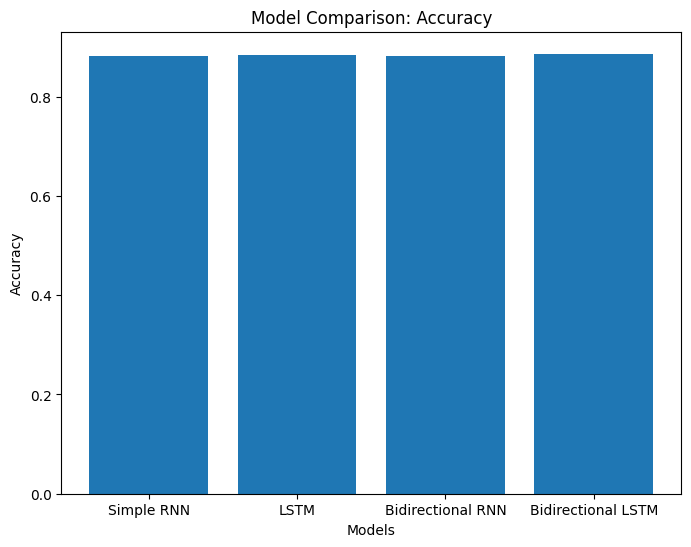

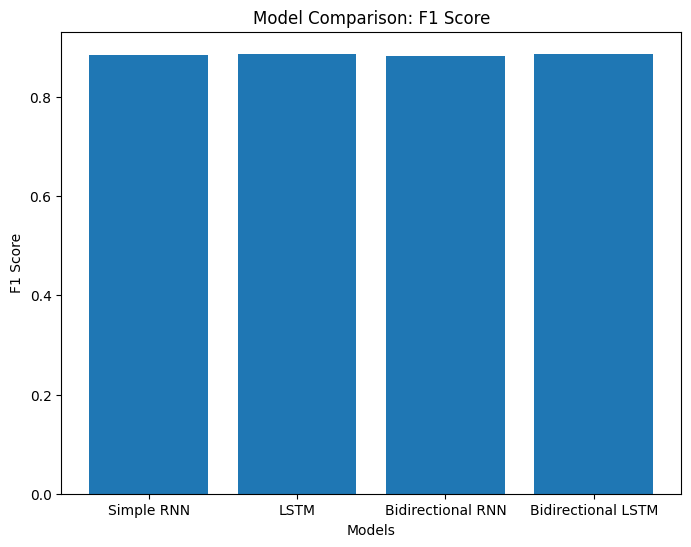

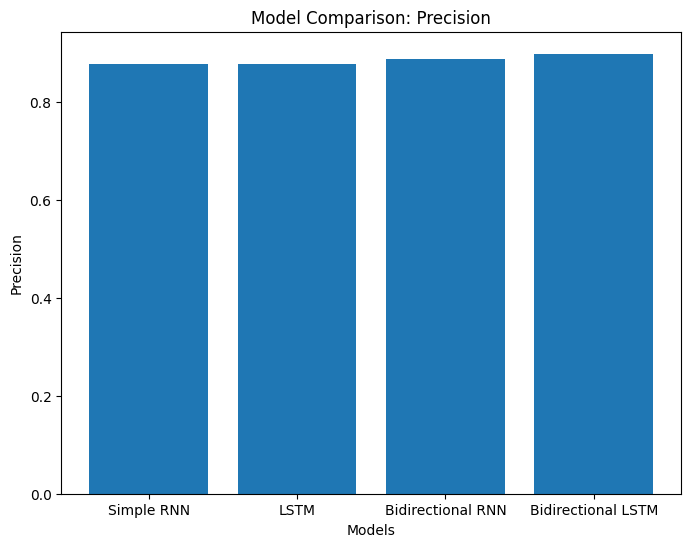

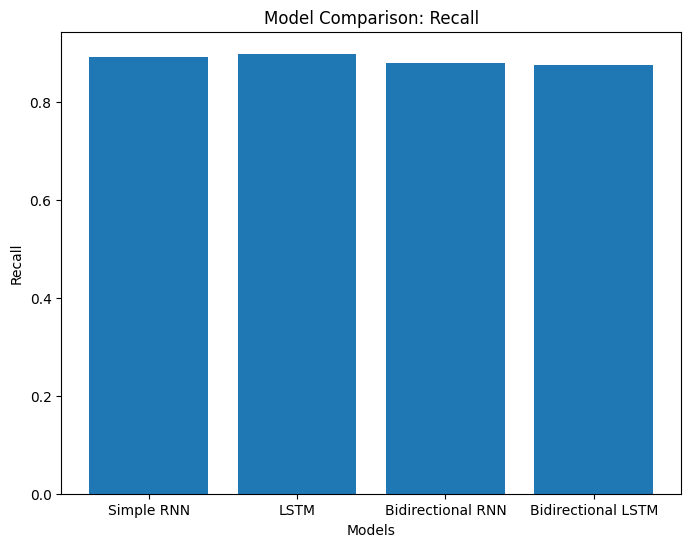

In [15]:
import matplotlib.pyplot as plt

# Function to calculate evaluation metrics and plot comparison graph
def evaluate_and_plot():
    models = ['Simple RNN', 'LSTM', 'Bidirectional RNN', 'Bidirectional LSTM']
    accuracy = []
    f1 = []
    precision = []
    recall = []

    # Evaluate each model and store metrics
    for model, y_pred in zip(
        ['rnn_model', 'lstm_model', 'bidirectional_rnn_model', 'bidirectional_lstm_model'],
        [
            rnn_model.predict(test_embeddings),
            lstm_model.predict(test_embeddings),
            bidirectional_rnn_model.predict(test_embeddings),
            bidirectional_lstm_model.predict(test_embeddings)
        ]
    ):
        y_pred_binary = (y_pred > 0.5).astype("int32")
        accuracy.append(accuracy_score(y_test, y_pred_binary))
        f1.append(f1_score(y_test, y_pred_binary))
        precision.append(precision_score(y_test, y_pred_binary))
        recall.append(recall_score(y_test, y_pred_binary))

    # Plot the results
    metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
    for metric, values in zip(metrics, [accuracy, f1, precision, recall]):
        plt.figure(figsize=(8, 6))
        plt.bar(models, values)
        plt.title(f'Model Comparison: {metric}')
        plt.ylabel(metric)
        plt.xlabel('Models')
        plt.show()

# Call the function to evaluate and plot
evaluate_and_plot()